In [ ]:
import matplotlib
matplotlib.use("qt4agg")
from bitfinex.backtest import data
from bitfinex import Client, TradeClient
import wget
# import holoviews as hv

%pylab inline

In [ ]:
import backtrader
import pandas as pd
# hv.notebook_extension('matplotlib')

In [ ]:
TC = TradeClient()
C = Client()

Let's Start by checking your balances. You need to have your keys stored somewhere the bitfinex client can find.

In [ ]:
TC.balances()

Let's Download some historic series:

In [5]:
wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz')

In [6]:
history = data.CSVDataSource('bitfinexUSD.csv.gz',fields=['datetime', 'price', 'volume'])
history.parse_timestamp_column('datetime',unit='s')


/usr/local/lib/python3.5/dist-packages/bitfinex-0.2.6-py3.5.egg/bitfinex/backtest/data.py:25: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp


In [7]:
print(history.data.info())
history.data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10182252 entries, 2013-03-31 22:07:48 to 2016-12-22 12:43:18
Data columns (total 2 columns):
price     float64
volume    float64
dtypes: float64(2)
memory usage: 233.1 MB
None


,price,volume
count,1.018225e+07,1.018225e+07
mean,4.245871e+02,2.526967e+00
std,1.866379e+02,9.093551e+00
min,1.000000e-02,1.000000e-08
25%,2.670000e+02,8.300000e-02
50%,3.900000e+02,4.890000e-01
75%,5.765400e+02,2.000000e+00
max,1.175000e+03,2.333891e+03


Fake open, high, low, close data

In [8]:
history.data['open'] = history.data.price
history.data['high'] = history.data.price
history.data['low'] = history.data.price
history.data['close'] = history.data.price
history.data[-50:]

,price,volume,open,high,low,close
datetime,,,,,,
2016-12-22 12:39:31,852.47,0.022000,852.47,852.47,852.47,852.47
2016-12-22 12:39:31,852.47,0.011462,852.47,852.47,852.47,852.47
2016-12-22 12:39:42,853.67,0.100000,853.67,853.67,853.67,853.67
2016-12-22 12:40:08,853.11,0.147445,853.11,853.11,853.11,853.11
2016-12-22 12:40:19,853.15,0.481716,853.15,853.15,853.15,853.15
2016-12-22 12:40:27,853.07,0.034427,853.07,853.07,853.07,853.07
2016-12-22 12:40:27,853.07,0.543000,853.07,853.07,853.07,853.07
2016-12-22 12:40:44,852.32,0.010000,852.32,852.32,852.32,852.32
2016-12-22 12:40:47,853.01,0.460000,853.01,853.01,853.01,853.01


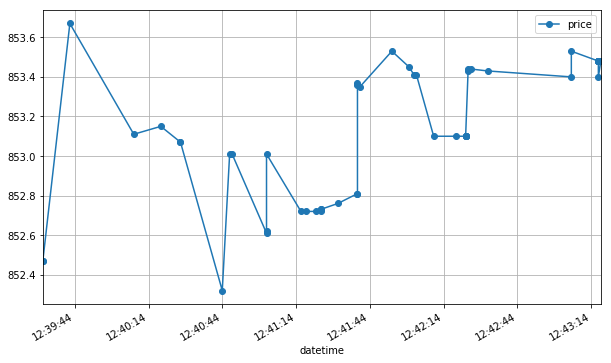

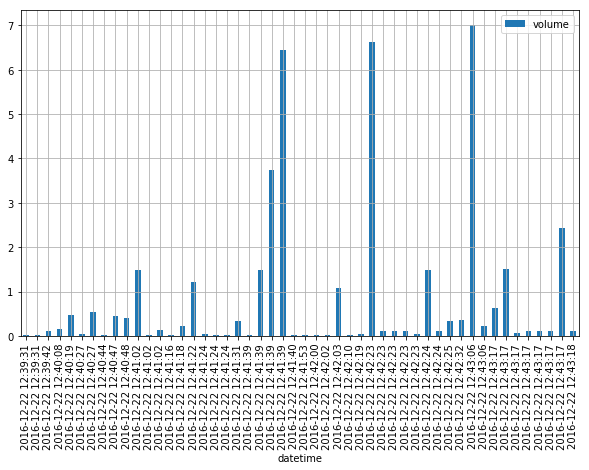

In [9]:
history.data[-50:].plot(y='price',figsize=(10,6), style='-o', grid=True);
history.data[-50:].plot(y='volume', kind='bar',figsize=(10,6), grid=True);

Creating a strategy

In [ ]:
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [ ]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [ ]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [ ]:
class MarcosStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 2
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
    def next(self):
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        if self.position.size:
            #self.price_in = self.data.close[0] if self.price_in is None else self.price_in
            print("Sell. Price: {}, price_out: {}, price_in:{}".format(self.data.close[0],self.price_out, self.price_in))
            if self.data.close[0] - self.price_in >= self.delta:
                #self.target =  self.data.close-self.trailing if self.data.close > self.target else self.target 
                #if self.data.close <= self.target:
                self.sell()
                self.price_out = self.data.close[0]
        elif self.data.close[0] - self.price_out <= -self.delta:
            
            print("{}.Price: {}, price_out: {}, price_in:{}".format(self.position.size,self.data.close[0],self.price_out, self.price_in))
            
            #self.target =  self.data.close+self.trailing if self.data.close < self.target else self.target 
            #if self.data.close >= self.target:
            self.buy()
            self.price_in = self.data.close[0]
                

In [ ]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=history.data[-50000:], datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
# cerebro.addstrategy(SMA_CrossOver)
cerebro.addstrategy(MarcosStrat)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

In [ ]:
cerebro.plot(numfigs=10)

In [ ]:
btind.AroonUp?

In [ ]:
LinePlotterIndicator(close_over_sma, name='Close_over_SMA)